In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import numpy
from PIL import Image

In [2]:
def load_data(dataset_path):
    img = Image.open(dataset_path)
    # 定义一个20 × 20的训练样本，一共有40个人，每个人都10张样本照片
    img_ndarray = np.asarray(img, dtype='float64') / 256
    #img_ndarray = np.asarray(img, dtype='float32') / 32

    # 记录脸数据矩阵，57 * 47为每张脸的像素矩阵
    faces = np.empty((400, 57 * 47))

    for row in range(20):
        for column in range(20):
            faces[20 * row + column] = np.ndarray.flatten(
                img_ndarray[row * 57: (row + 1) * 57, column * 47 : (column + 1) * 47]
            )

    label = np.zeros((400, 40))
    for i in range(40):
        label[i * 10: (i + 1) * 10, i] = 1

    # 将数据分成训练集，验证集，测试集
    train_data = np.empty((320, 57 * 47))
    train_label = np.zeros((320, 40))
    vaild_data = np.empty((40, 57 * 47))
    vaild_label = np.zeros((40, 40))
    test_data = np.empty((40, 57 * 47))
    test_label = np.zeros((40, 40))

    for i in range(40):
        train_data[i * 8: i * 8 + 8] = faces[i * 10: i * 10 + 8]
        train_label[i * 8: i * 8 + 8] = label[i * 10: i * 10 + 8]

        vaild_data[i] = faces[i * 10 + 8]
        vaild_label[i] = label[i * 10 + 8]

        test_data[i] = faces[i * 10 + 9]
        test_label[i] = label[i * 10 + 9]

    train_data = train_data.astype('float32')
    vaild_data = vaild_data.astype('float32')
    test_data = test_data.astype('float32')
    print train_data.shape
    print train_label[0]
    print train_label[30]
    print train_label[300]
    print vaild_data.shape

    return [
        (train_data, train_label),
        (vaild_data, vaild_label),
        (test_data, test_label)
    ]



In [3]:
def convolutional_layer(data, kernel_size, bias_size, pooling_size):
    kernel = tf.get_variable("conv", kernel_size, initializer=tf.random_normal_initializer())
    bias = tf.get_variable('bias', bias_size, initializer=tf.random_normal_initializer())

    conv = tf.nn.conv2d(data, kernel, strides=[1, 1, 1, 1], padding='SAME')
    linear_output = tf.nn.relu(tf.add(conv, bias))
    pooling = tf.nn.max_pool(linear_output, ksize=pooling_size, strides=pooling_size, padding="SAME")
    return pooling

In [4]:
def linear_layer(data, weights_size, biases_size):
    weights = tf.get_variable("weigths", weights_size, initializer=tf.random_normal_initializer())
    biases = tf.get_variable("biases", biases_size, initializer=tf.random_normal_initializer())
    return tf.add(tf.matmul(data, weights), biases)

In [5]:
def convolutional_neural_network(data):


    data = tf.reshape(data, [-1, 57, 47, 1])

    # 经过第一层卷积神经网络后，得到的张量shape为：[batch, 29, 24, 32]
    with tf.variable_scope("conv_layer1") as layer1:
        layer1_output = convolutional_layer(
            data=data,
            kernel_size=kernel_shape1,
            bias_size=bias_shape1,
            pooling_size=[1, 2, 2, 1]
        )
    # 经过第二层卷积神经网络后，得到的张量shape为：[batch, 15, 12, 64]
    with tf.variable_scope("conv_layer2") as layer2:
        layer2_output = convolutional_layer(
            data=layer1_output,
            kernel_size=kernel_shape2,
            bias_size=bias_shape2,
            pooling_size=[1, 2, 2, 1]
        )
    with tf.variable_scope("full_connection") as full_layer3:
        # 讲卷积层张量数据拉成2-D张量只有有一列的列向量
        layer2_output_flatten = tf.contrib.layers.flatten(layer2_output)
        print("vec:=====:",layer2_output_flatten)
        layer3_output = tf.nn.relu(
            linear_layer(
                data=layer2_output_flatten,
                weights_size=full_conn_w_shape,
                biases_size=full_conn_b_shape
            )
        )
        print("lay3out:=====:",layer3_output)
        print("lay3out[1]:=====:",layer3_output[1])
        print("lay3out[2]:=====:",layer3_output[2])
        # layer3_output = tf.nn.dropout(layer3_output, 0.8)
    with tf.variable_scope("output") as output_layer4:
        output = linear_layer(
            data=layer3_output,
            weights_size=out_w_shape,
            biases_size=out_b_shape
        )

    vec = output
    print("vexaaaa",vec)

    return output;

In [6]:
def train_facedata(dataset, model_dir,model_path):
    # train_set_x = data[0][0]
    # train_set_y = data[0][1]
    # valid_set_x = data[1][0]
    # valid_set_y = data[1][1]
    # test_set_x = data[2][0]
    # test_set_y = data[2][1]
    # X = tf.placeholder(tf.float32, shape=(None, None), name="x-input")  # 输入数据
    # Y = tf.placeholder(tf.float32, shape=(None, None), name='y-input')  # 输入标签

    batch_size = 40

    # train_set_x, train_set_y = dataset[0]
    # valid_set_x, valid_set_y = dataset[1]
    # test_set_x, test_set_y = dataset[2]
    train_set_x = dataset[0][0]
    train_set_y = dataset[0][1]
    valid_set_x = dataset[1][0]
    valid_set_y = dataset[1][1]
    test_set_x = dataset[2][0]
    test_set_y = dataset[2][1]

    X = tf.placeholder(tf.float32, [batch_size, 57 * 47])
    Y = tf.placeholder(tf.float32, [batch_size, 40])
    print("Y=",Y)

    predict = convolutional_neural_network(X)
    cost_func = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=predict, labels=Y))
    #cost_func = tf.reduce_mean(tf.nn.log_softmax(predict[0,:]+predict[1,:]))
    optimizer = tf.train.AdamOptimizer(1e-2).minimize(cost_func)

    # 用于保存训练的最佳模型
    saver = tf.train.Saver()
    #model_dir = './model'
    #model_path = model_dir + '/best.ckpt'
    with tf.Session() as session:
        # 若不存在模型数据，需要训练模型参数
        if not os.path.exists(model_path + ".index"):
            session.run(tf.global_variables_initializer())
            best_loss = float('Inf')
            for epoch in range(20):
                epoch_loss = 0
                for i in range((int)(np.shape(train_set_x)[0] / batch_size)):
                    x = train_set_x[i * batch_size: (i + 1) * batch_size]
                    y = train_set_y[i * batch_size: (i + 1) * batch_size]
                    _, cost = session.run([optimizer, cost_func], feed_dict={X: x, Y: y})
                    print cost_func
                    #print optimizer
                    epoch_loss += cost
                #print(predict.eval())
               # print output.eval()
                print(epoch, ' : ', epoch_loss)
                if best_loss > epoch_loss:
                    best_loss = epoch_loss
                    if not os.path.exists(model_dir):
                        os.mkdir(model_dir)
                        print("create the directory: %s" % model_dir)
                    save_path = saver.save(session, model_path)
                    print("Model saved in file: %s" % save_path)

        # 恢复数据并校验和测试
        saver.restore(session, model_path)
        correct = tf.equal(tf.argmax(predict,1), tf.argmax(Y,1))
        valid_accuracy = tf.reduce_mean(tf.cast(correct,'float'))
        print('valid set accuracy: ', valid_accuracy.eval({X: valid_set_x, Y: valid_set_y}))

        test_pred = tf.argmax(predict, 1).eval({X: test_set_x})
        test_true = np.argmax(test_set_y, 1)
        test_correct = correct.eval({X: test_set_x, Y: test_set_y})
        incorrect_index = [i for i in range(np.shape(test_correct)[0]) if not test_correct[i]]
        for i in incorrect_index:
            print('picture person is %i, but mis-predicted as person %i'
                %(test_true[i], test_pred[i]))
        plot_errordata(incorrect_index, "olivettifaces.gif")
        print predict

In [7]:
#画出在测试集中错误的数据
def plot_errordata(error_index, dataset_path):
    img = mpimg.imread(dataset_path)
    plt.imshow(img)
    currentAxis = plt.gca()
    for index in error_index:
        print index
        row = index // 2
        column = index % 2
        currentAxis.add_patch(
            patches.Rectangle(
                xy=(
                     47 * 9 if column == 0 else 47 * 19,
                     row * 57
                    ),
                width=47,
                height=57,
                linewidth=1,
                edgecolor='r',
                facecolor='none'
            )
    )
    plt.savefig("result.png")
    plt.show()

(320, 2679)
[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.]
[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  1.  0.  0.]
(40, 2679)
('Y=', <tf.Tensor 'Placeholder_1:0' shape=(40, 40) dtype=float32>)
('vec:=====:', <tf.Tensor 'full_connection/Flatten/Reshape:0' shape=(40, 11520) dtype=float32>)
('lay3out:=====:', <tf.Tensor 'full_connection/Relu:0' shape=(40, 1024) dtype=float32>)
('lay3out[1]:=====:', <tf.Tensor 'full_connection/strided_slice:0' shape=(1024,) dtype=float32>)
('lay3out[2]:=====:', <tf.Tensor 'full_connection/strided_slice_1:0' shape=(1024,) dtype=float32>)
('vexaaaa', <tf.Tensor 'output/Add:0' 

Tensor("Mean:0", shape=(), dtype=float32)
Tensor("Mean:0", shape=(), dtype=float32)
Tensor("Mean:0", shape=(), dtype=float32)
Tensor("Mean:0", shape=(), dtype=float32)
(18, ' : ', 0.0)
Tensor("Mean:0", shape=(), dtype=float32)
Tensor("Mean:0", shape=(), dtype=float32)
Tensor("Mean:0", shape=(), dtype=float32)
Tensor("Mean:0", shape=(), dtype=float32)
Tensor("Mean:0", shape=(), dtype=float32)
Tensor("Mean:0", shape=(), dtype=float32)
Tensor("Mean:0", shape=(), dtype=float32)
Tensor("Mean:0", shape=(), dtype=float32)
(19, ' : ', 0.0)
INFO:tensorflow:Restoring parameters from ./model/best.ckpt
('valid set accuracy: ', 0.72500002)
picture person is 0, but mis-predicted as person 30
picture person is 5, but mis-predicted as person 35
picture person is 15, but mis-predicted as person 35
picture person is 17, but mis-predicted as person 35
picture person is 29, but mis-predicted as person 31
picture person is 32, but mis-predicted as person 36
picture person is 33, but mis-predicted as person

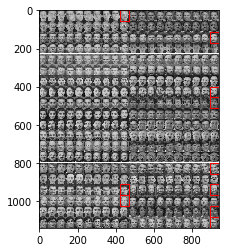

Tensor("output/Add:0", shape=(40, 40), dtype=float32)


In [8]:
def main():
    dataset_path = "olivettifaces.gif"
    data = load_data(dataset_path)
    model_dir = './model'
    model_path = model_dir + '/best.ckpt'
    train_facedata(data, model_dir, model_path)

if __name__ == "__main__" :
            # 根据类别个数定义最后输出层的神经元
    n_ouput_layer = 40

    kernel_shape1=[5, 5, 1, 32]
    kernel_shape2=[5, 5, 32, 64]
    full_conn_w_shape = [15 * 12 * 64, 1024]
    out_w_shape = [1024, n_ouput_layer]

    bias_shape1=[32]
    bias_shape2=[64]
    full_conn_b_shape = [1024]
    out_b_shape = [n_ouput_layer]
    
    main()

In [ ]:
cost_func